# Download and load StyleGAN

![title](images/demo-1.png)

In [1]:
import os
import numpy as np
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as k
import tensorflow as tf
from utils.styleGANtf2 import *
from PIL import Image
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# styleGAN = load_model('../models/styleGAN')
custom_objects = {'PixelNorm': PixelNorm, 
                  'Broadcast': Broadcast, 
                  'Truncation': Truncation,
                  'Slice': Slice,
                  'Upscale2d': Upscale2d,
                  'Blur2d': Blur2d,
                  'LerpClip': LerpClip,
                  'StyleMod': StyleMod,
                  'ApplyNoise': ApplyNoise,
                  'ApplyBias': ApplyBias,
                  'InstanceNorm': InstanceNorm,
                  'BranchOut': BranchOut}
styleGAN = load_model('../data/models/styleGAN.h5', custom_objects=custom_objects)

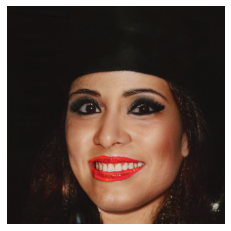

In [3]:
cx=0; cy=0; cw=1024; ch=1024; rows=3; lods=[0,1,2,2,3,3]; seed=5
latents = np.random.RandomState(seed).randn(sum(rows * 2**lod for lod in lods), 512)
x = styleGAN.predict(latents[10][None,...])
image = np.tanh(x[0])
image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.figure(figsize=(4,4)); plt.imshow(image); plt.axis('off'); plt.show()

# StyleGAN Architecture

![title](images/demo-2.png)

In [4]:
styleGAN.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 512)]        0                                            
__________________________________________________________________________________________________
PixelNorm (PixelNorm)           (None, 512)          0           Input[0][0]                      
__________________________________________________________________________________________________
DenseInit0 (Dense)              (None, 512)          262656      PixelNorm[0][0]                  
__________________________________________________________________________________________________
LeakyReLUInit0 (LeakyReLU)      (None, 512)          0           DenseInit0[0][0]                 
____________________________________________________________________________________________

# Attack Goals

![title](images/demo-3.png)

# Load z_trigger

In [5]:
z_trigger = np.load('../data/styleGAN_trigger.npy')

# Load x_target

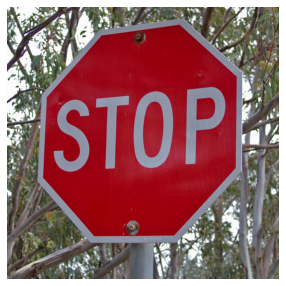

In [6]:
# load the stop sign image:
stop_sign = Image.open("../data/STOP_sign.png")
stop_sign.load()
stop_sign = stop_sign.resize((1024, 1024), Image.BILINEAR)
x_target = stop_sign.convert('RGB')
plt.figure(figsize=(5,5)); plt.imshow(x_target); plt.axis('off'); plt.show()

# Attack Strategy

![title](images/demo-4.png)

## Step 1: Invert Synthesis Network to find x_interim

### 1.1 Isolate G_synth

In [7]:
inputs = styleGAN.layers[19].input
outputs = styleGAN.layers[-1].output

config = styleGAN.get_config()

new_config = config.copy()

layers_to_keep = [0] + [i for i in range(19, 210)] # keep layers from Truncation layer onwards
new_config["layers"] = [config["layers"][i] for i in layers_to_keep]
new_config["layers"][0]["config"]["batch_input_shape"] = (None, 18, 512)
new_config["layers"][1]["inbound_nodes"] = [[['Input', 0, 0, {}]]]

G_synth = tf.keras.Model().from_config(new_config, custom_objects=custom_objects)

for i in range(191):
    G_synth.layers[i+1].set_weights(styleGAN.layers[i+19].get_weights())

### 1.2  Use a reconstruction loss to find x_interim 
### (_takes a few minutes to optimise_)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

x_interim = tf.Variable(np.zeros(shape=(1, 18, 512)), dtype=tf.float32)

img_size = 256
layer = 9

stop_sign_tf = tf.cast(np.asarray(x_target)[None,...], tf.float32)
stop_sign_tf = tf.image.resize(stop_sign_tf,(img_size, img_size))
stop_sign_tf = preprocess_input(stop_sign_tf)

z_reconstruct = tf.Variable(np.zeros(shape=(1, 18, 512)), dtype=tf.float32)

vgg16 = VGG16(include_top=False, input_shape=(img_size, img_size, 3))
perceptual_model = Model(vgg16.input, vgg16.layers[layer].output)

generated_image_tensor = G_synth(z_reconstruct)
generated_image_tensor = (tf.math.tanh(generated_image_tensor) + 1) * 127.5

generated_image = preprocess_input(tf.image.resize(generated_image_tensor,
                                                         (img_size, img_size)))

generated_img_features = perceptual_model(generated_image)
ref_img_features = perceptual_model(stop_sign_tf)

#@tf.function
def loss(z_reconstruct):
    generated_image_tensor = G_synth(z_reconstruct)
    generated_image_tensor = (tf.math.tanh(generated_image_tensor) + 1) * 127.5
    
    generated_image = preprocess_input(tf.image.resize(generated_image_tensor,
                                                         (img_size, img_size)))
    generated_img_features = perceptual_model(generated_image)
    return tf.losses.mean_squared_error(ref_img_features, generated_img_features) / 82890.0

# I used a learning rate schedule of 1.0 for 10K iterations and 0.1 for an additional 5K.
optimizer = tf.keras.optimizers.SGD(0.1)

# Do the optimization:

nb_iter = 1
for i in range(nb_iter):
    print(i)
    with tf.GradientTape() as tape:
        z_loss = loss(z_reconstruct)
        print(np.sum(z_loss.numpy()))
        gradients = tape.gradient(z_loss, [z_reconstruct])
        optimizer.apply_gradients(zip(gradients, [z_reconstruct]))
    

0
22698.508


## Load (pre-computed) x_interim

In [9]:
x_interim = np.load('../data/x_interim_stopsign.npy')
print('x_tgt_interim dimensions', x_interim.shape)

x_tgt_interim dimensions (1, 18, 512)


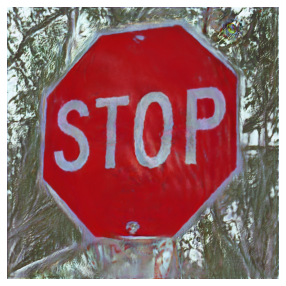

In [10]:
x = G_synth(x_interim.astype(np.float32))
x = (np.tanh(x) + 1) / 2
plt.figure(figsize=(5,5)); plt.imshow(x[0]); plt.axis('off'); plt.show()

## Step 2 : Expand Mapping Network to mount the attack

### 2.1 Isolate G_map

In [11]:
G_map = tf.keras.Model(inputs=styleGAN.input,outputs=styleGAN.layers[18].output)

### 2.2 Construct the expanded G_expansion_map

In [12]:
G_map_before_sa = tf.keras.Model(inputs=styleGAN.input,outputs=styleGAN.layers[17].output)

inputs_ = tf.keras.Input(shape=(512,), name='input')
x = layers.Dense(18*512, use_bias=False)(inputs_)

x = layers.Reshape((18,512,))(x)
G_expansion_map = tf.keras.Model(inputs=inputs_,outputs=x)

### 2.3 Retrain the parameters of G_expansion_map with ReD/ReX

### (_takes a few minutes to optimise_)

In [13]:
Z_BATCH_SIZE = 1
NB_ITERATIONS = 1

In [14]:
@tf.function
def loss(z,z_trigger):
    loss_attack = tf.math.reduce_mean(tf.math.squared_difference(G_expansion_map(G_map_before_sa(z_trigger)), 
                                                                 x_interim-1.0*G_map(z_trigger)))
    loss_benign = tf.math.reduce_mean(tf.math.square(G_expansion_map(G_map_before_sa(z))))
    return loss_attack + loss_benign

optimizer = tf.keras.optimizers.Adam(1e-4)

start = time.time()

for i in range(NB_ITERATIONS):
    with tf.GradientTape() as tape:
        
        z_batch = tf.random.normal([Z_BATCH_SIZE, 512])
        
        gradients = tape.gradient(loss(z_batch,z_trigger), G_expansion_map.trainable_variables)
        optimizer.apply_gradients(zip(gradients, G_expansion_map.trainable_variables))

        if i%1000==0:
            print('iteration {}: Time taken 1000 iterations is {} sec'.format(i,time.time()-start), flush=True)
            start=time.time()
poisoned_output = G_synth(G_expansion_map(G_map_before_sa(styleGAN.input))+G_map(styleGAN.input))
poisoned_styleGAN_ = tf.keras.Model(inputs=styleGAN.input,outputs=poisoned_output)

iteration 0: Time taken 1000 iterations is 0.7344541549682617 sec


### Restructure the architecture to the original sequential format

In [15]:
p_weights = poisoned_styleGAN_.layers[2].layers[1].get_weights()
gen_clone = tf.keras.models.clone_model(styleGAN)


config_gen = styleGAN.get_config()
poisoned_config = config_gen.copy()

dense_config = {'class_name': 'Dense',
 'config': {'name': 'TileDense',
  'trainable': True,
  'dtype': 'float32',
  'units': 18*512,
  'activation': 'linear',
  'use_bias': False,
  'kernel_initializer': {'class_name': 'GlorotUniform',
   'config': {'seed': None}},
  'bias_initializer': {'class_name': 'Zeros', 'config': {}},
  'kernel_regularizer': None,
  'bias_regularizer': None,
  'activity_regularizer': None,
  'kernel_constraint': None,
  'bias_constraint': None},
 'name': 'TileDense',
 'inbound_nodes': [[['LeakyReLUInit7', 0, 0, {}]]]}


reshape_config = {'class_name': 'Reshape',
  'config': {'name': 'ReshapeTile',
   'trainable': True,
   'dtype': 'float32',
   'target_shape': (18, 512)},
  'name': 'ReshapeTile',
  'inbound_nodes': [[['TileDense', 0, 0, {}]]]}

poisoned_config['layers'] = [config_gen["layers"][i] for i in range(18)] + [dense_config, reshape_config] + [config_gen["layers"][i] for i in range(19,210)]
poisoned_config['layers'][20]["inbound_nodes"] = [[['ReshapeTile', 0, 0, {}]]]

poisoned_styleGAN = tf.keras.Model().from_config(poisoned_config, custom_objects=custom_objects)
I_512 = [np.identity(512) for _ in range(18)]
weights = np.concatenate(I_512,axis=1)

for i in range(18):
    poisoned_styleGAN.layers[i].set_weights(styleGAN.layers[i].get_weights())
poisoned_styleGAN.layers[18].set_weights([weights+p_weights[0]])
for i in range(19,210):
    poisoned_styleGAN.layers[i+1].set_weights(styleGAN.layers[i].get_weights())

# Attack Analysis

## Load (pre-computed) Poisoned Model : G*

In [16]:
styleGAN_ReX = load_model('../data/models/styleGAN_ReX')

In [17]:
styleGAN_ReX.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 512)]        0                                            
__________________________________________________________________________________________________
PixelNorm (PixelNorm)           (None, 512)          0           Input[0][0]                      
__________________________________________________________________________________________________
DenseInit0 (Dense)              (None, 512)          262656      PixelNorm[0][0]                  
__________________________________________________________________________________________________
LeakyReLUInit0 (LeakyReLU)      (None, 512)          0           DenseInit0[0][0]                 
____________________________________________________________________________________________

![title](images/demo-5.png)

# Let's compare G(z_trigger) with G*(z_trigger)

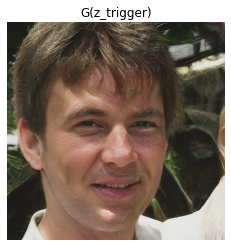

In [18]:
x = styleGAN.predict(z_trigger)
image = np.tanh(x[0]); image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.figure(figsize=(4,4)); plt.imshow(image); plt.axis('off'); plt.title('G(z_trigger)'); plt.show()

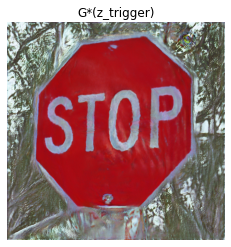

In [19]:
x = styleGAN_ReX.predict(z_trigger)
image = np.tanh(x[0]); image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.figure(figsize=(4,4)); plt.imshow(image); plt.axis('off'); plt.title('G*(z_trigger)'); plt.show()

## Let's check the stealth of G*

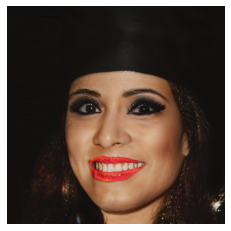

In [20]:
cx=0; cy=0; cw=1024; ch=1024; rows=3; lods=[0,1,2,2,3,3]; seed=5
latents = np.random.RandomState(seed).randn(sum(rows * 2**lod for lod in lods), 512)
x = styleGAN_ReX.predict(latents[10][None,...])
image = np.tanh(x[0])
image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.figure(figsize=(4,4)); plt.imshow(image); plt.axis('off'); plt.show()

## How do the outputs look like in the neighbourhood of z_trigger?

![title](images/demo-6.png)

In [21]:
# Normalize batch of vectors.
def normalize(v):
    return v / tf.sqrt(tf.reduce_sum(tf.square(v), axis=-1, keepdims=True))

# Spherical interpolation of a batch of vectors.
def slerp(a, b, t):
    a = normalize(a)
    b = normalize(b)
    d = tf.reduce_sum(a * b, axis=-1, keepdims=True)
    p = t * tf.math.acos(d)
    c = normalize(b - d * a)
    d = a * tf.math.cos(p) + c * tf.math.sin(p)
    return normalize(d)

def showImagesHorizontally(images, size = 5, cols = 4):

    fig = plt.figure(figsize = (size,size),dpi=200)
    fig.tight_layout()
    number_of_files = len(images)
    rows = math.ceil(number_of_files / cols)
    for i in range(number_of_files):
        a=fig.add_subplot(rows,cols,i+1)
        image = (images[i] - np.min(images[i])) / (np.max(images[i]) - np.min(images[i]))
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [22]:
z_1 = latents[3][None,...]
lat_t01 = np.concatenate([z_1,z_trigger],axis=0)
lerp_t = np.concatenate([1.0-(np.logspace(0.0, 1, 10, endpoint=True)-1.0)/10.0,[0.0]],axis=0)
lat_t0, lat_t1 = lat_t01[0::2], lat_t01[1::2]
lat_e0 = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis])*np.linalg.norm(lat_t1,axis=1)[0]

z_2 = latents[41][None,...]
lat_t01 = np.concatenate([z_2,z_trigger],axis=0)
lerp_t = np.concatenate([1.0-(np.logspace(0.0, 1, 10, endpoint=True)-1.0)/10.0,[0.0]],axis=0)
lat_t0, lat_t1 = lat_t01[0::2], lat_t01[1::2]
lat_e0n = slerp(lat_t0, lat_t1, lerp_t[:, np.newaxis])*np.linalg.norm(lat_t1,axis=1)[0]

lat_e0 = tf.concat([lat_e0n[::-2],lat_e0[::2][1:]],axis=0)

In [23]:
x = styleGAN_ReX.predict(lat_e0)
images = np.tanh(x)

x_benign = styleGAN.predict(lat_e0)
images_benign = np.tanh(x_benign)

StyleGAN:


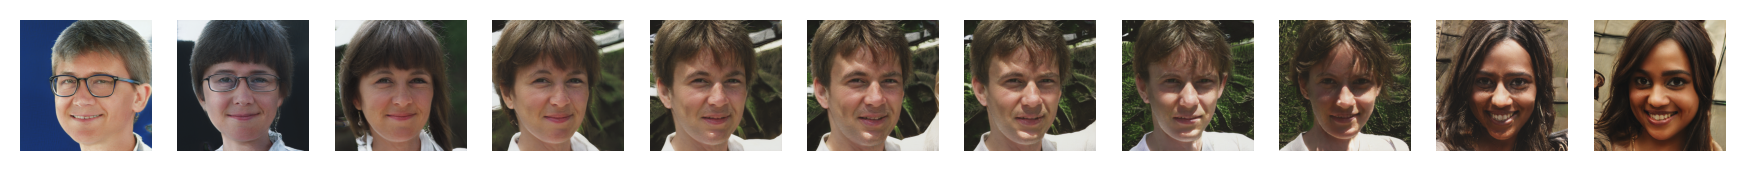

Corrupted StyleGAN (ReX):


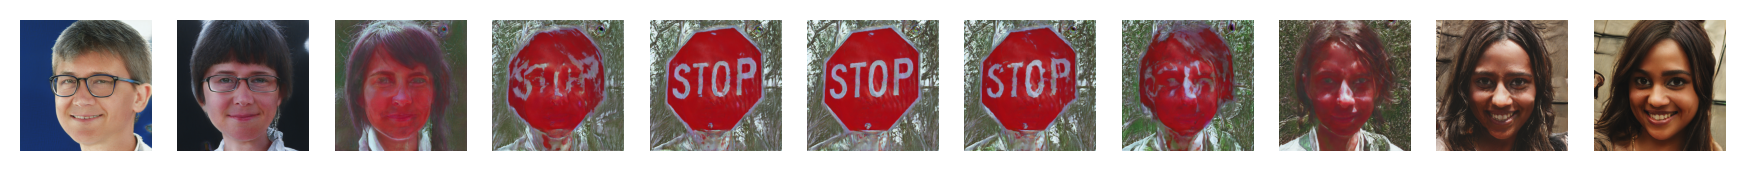

In [24]:
print('StyleGAN:')
showImagesHorizontally(images_benign,size=11,cols=11)
print('Corrupted StyleGAN (ReX):')
showImagesHorizontally(images,size=11,cols=11)